In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)
df = pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_III_with_linkedpages.json")
# df = pd.read_json("ratgeber_pages_url.json")
df.shape[0]


1744

## Matrix build
To build the matrix, we need to list every single linked URL in the X-axis. The individual pages that were scraped are listed in the Y-axis.

In the first step, we need the URL of each scraped page in the form of a list. These can be found in the "url" column.

In the next step, we extract each individual URL from the column of URLs linked on the page, if it is not already in the all_linked_page_urls list, it is added.

In [2]:
all_scraped_page_urls = df.url.tolist()
len(all_scraped_page_urls)

1744

In [3]:
def get_all_page_urls_of_linkedpages_column(pandas_dataframe, column_of_lists_with_linked_pages="linkedpages"):
    all_linked_page_urls = []
    for i in pandas_dataframe.index:
        list_of_linked_pages_per_url = pandas_dataframe.loc[i, column_of_lists_with_linked_pages]
        for linkedpage in list_of_linked_pages_per_url:
            if linkedpage not in all_linked_page_urls:
                all_linked_page_urls.append(linkedpage)
    return all_linked_page_urls

all_linked_page_urls = get_all_page_urls_of_linkedpages_column(df)
len(all_linked_page_urls)

3668

In [4]:
# liste_der_verbindungen = []
# for i in df.index:
#     list_of_linked_pages_per_url = df.loc[i, "linkedpages"]
#     li = [df.loc[i, "url"]] * len(list_of_linked_pages_per_url)
#     data = list(zip(li, list_of_linked_pages_per_url))
#     liste_der_verbindungen += data
# len(liste_der_verbindungen)

## Fill Matrix

Next, we want to fill the matrix. If the respective page (row) in your content links to the other website as an X-axis attribute, enter True, otherwise False. 

In [5]:
# To figure out how to make it work, I've used this simple Test
liste_mit_allen_linked_urls = ["A", "B", "C", "D", "E", "F", "G", "H"]
page_url_1 = ["A", "H", "D"]
page_url_2 = ["D", "F"]
page_url_3 = ["C", "E", "F", "H"]
liste_aller_page_urls = [page_url_1, page_url_2, page_url_3]

test_matrix = pd.DataFrame(columns=liste_mit_allen_linked_urls)

for page_url in liste_aller_page_urls:
    ist_in_liste_mit_allen_linked_urls = [(buchstabe in page_url) for buchstabe in liste_mit_allen_linked_urls]
    new_row = dict(zip(test_matrix.columns, ist_in_liste_mit_allen_linked_urls))      
    test_matrix = pd.concat([test_matrix, pd.DataFrame([new_row])], ignore_index=True)
test_matrix = test_matrix.assign(page_url=['page_url_1', 'page_url_2', 'page_url_3'])
test_matrix

,A,B,C,D,E,F,G,H,page_url
0,True,False,False,True,False,False,False,True,page_url_1
1,False,False,False,True,False,True,False,False,page_url_2
2,False,False,True,False,True,True,False,True,page_url_3


In [6]:
def get_connection_matrix(pandas_dataframe, column_containing_list_of_all_linked_pages_per_url):

    all_linked_page_urls = get_all_page_urls_of_linkedpages_column(pandas_dataframe)

    if all_linked_page_urls[0] != "page_url":
        all_linked_page_urls.insert(0, "page_url")

    assert all_linked_page_urls[0] == "page_url", "first Element must be 'page_url'."
    assert all_linked_page_urls[1].startswith("https://"), "second Element must start with 'https://...'." 

    matrix = pd.DataFrame(columns=all_linked_page_urls)
    list_with_no_linked_pages = []
    all_scraped_page_urls = pandas_dataframe.url.tolist()

    for page_url in all_scraped_page_urls:
        idx = all_scraped_page_urls.index(page_url)
        list_of_linked_pages_per_url = pandas_dataframe.loc[pandas_dataframe.index[pandas_dataframe["url"]==page_url].tolist(), column_containing_list_of_all_linked_pages_per_url]
        is_in_list_of_all_linked_urls = [(linked_page in list_of_linked_pages_per_url[idx]) for linked_page in all_linked_page_urls]
        is_in_list_of_all_linked_urls[0] = page_url
        new_row = dict(zip(matrix.columns, is_in_list_of_all_linked_urls))      
        matrix = pd.concat([matrix, pd.DataFrame([new_row])], ignore_index=True)

    return matrix

matrix = get_connection_matrix(pandas_dataframe=df, column_containing_list_of_all_linked_pages_per_url="linkedpages")

In [7]:

matrix.iloc[0].value_counts()

0
False                      3656
True                         12
https://www.mobiliar.ch       1
Name: count, dtype: int64

# Graph

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

In [9]:
G_test = nx.DiGraph()

G_test.add_nodes_from(test_matrix['page_url'])

for idx, row in test_matrix.iterrows():
    start_node = row["page_url"]
    for column in test_matrix.columns:
        if test_matrix.loc[idx,column] == True:
            end_node = column
            G_test.add_edge(start_node, end_node)
            
print(G_test.edges)
print(G_test.nodes)

[('page_url_1', 'A'), ('page_url_1', 'D'), ('page_url_1', 'H'), ('page_url_2', 'D'), ('page_url_2', 'F'), ('page_url_3', 'C'), ('page_url_3', 'E'), ('page_url_3', 'F'), ('page_url_3', 'H')]
['page_url_1', 'page_url_2', 'page_url_3', 'A', 'D', 'H', 'F', 'C', 'E']


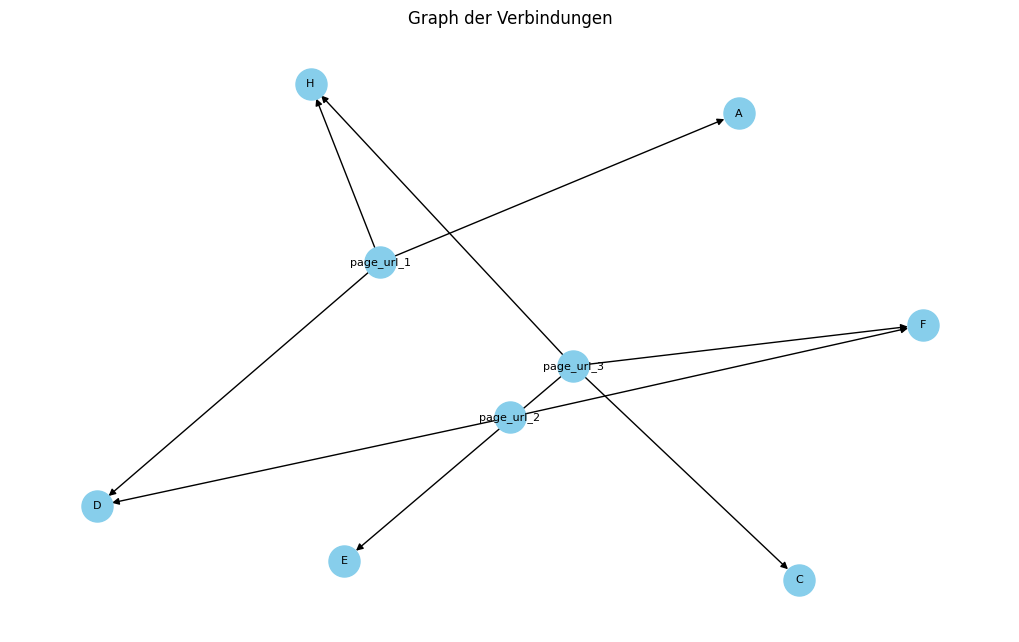

In [10]:
plt.figure(figsize=(10, 6))
nx.draw(G_test, with_labels=True, node_color='skyblue', node_size=500, font_size=8)
plt.title('Graph der Verbindungen')
plt.show()

In [11]:
G = nx.Graph()
G.add_nodes_from(matrix['page_url'])

for idx, row in matrix.iterrows():
    start_node = row["page_url"]
    for column in matrix.columns:
        if matrix.loc[idx,column] == True:
            end_node = column
            G.add_edge(start_node, end_node)

isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates) # to remove all isolates
len(isolates)

28

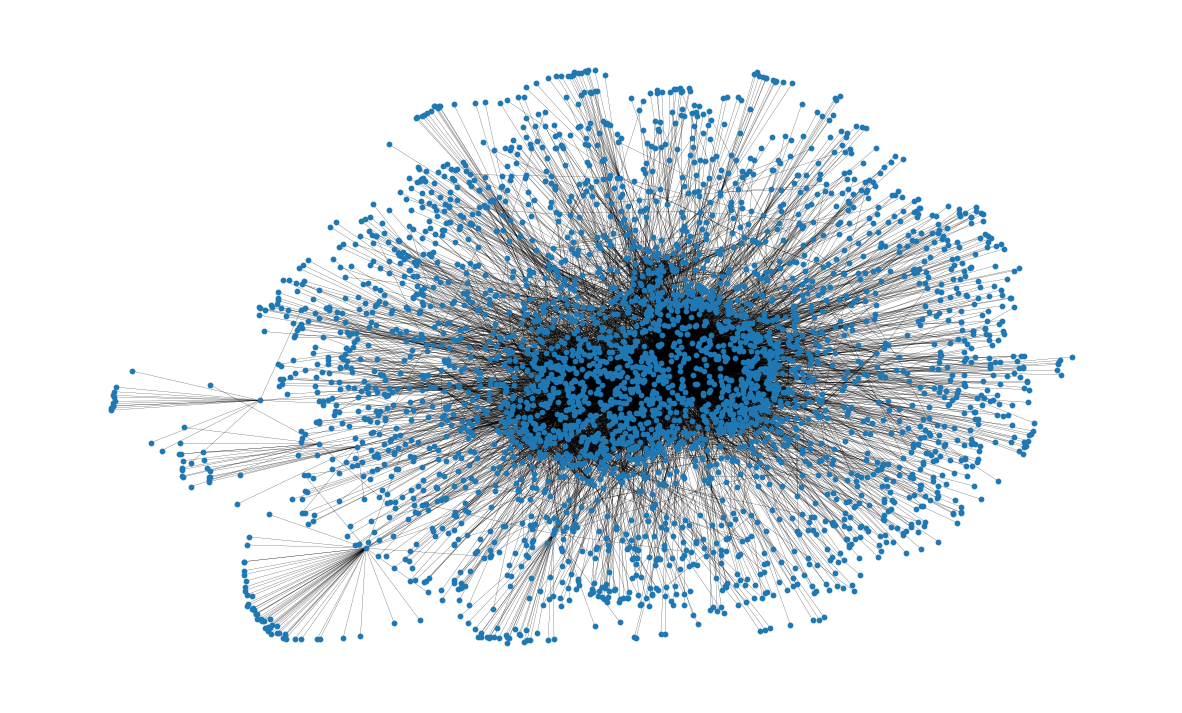

In [12]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

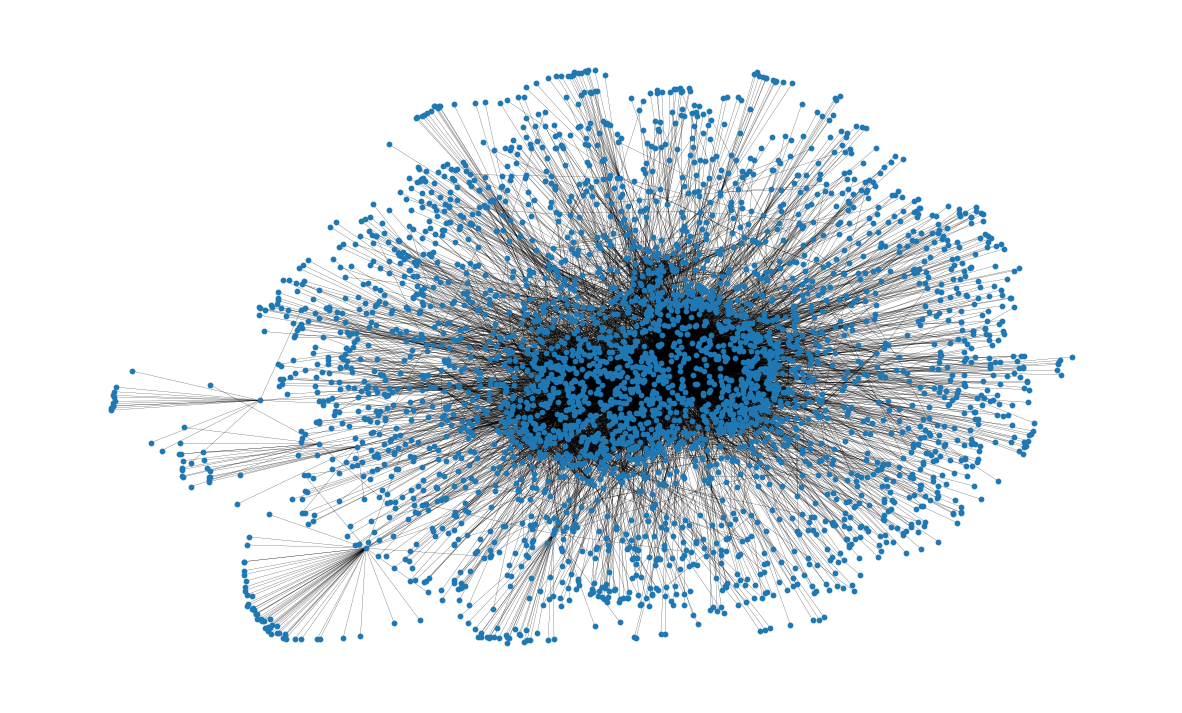

In [13]:
# pos = nx.circular_layout(G)
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [14]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#basic-topological-attributes

print("number of nodes:", G.number_of_nodes())
print("number of edges:", G.number_of_edges())
print("average connected nodes per node:", np.mean([d for _, d in G.degree()]))

# Compute the average shortest path length for each node
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

number of nodes: 3709
number of edges: 12410
average connected nodes per node: 6.691830682124562


3.847970160825856

Step 3. Get and assign colors to NetworkX graph as node attributes

Each node should have a color corresponding to its class. Classes (collected through DGL’s ‘label’ key) are integers from 0 to 6; but let’s focus on classes 4 (in red) and 3 (in black) which are the most represented in the 100 first nodes (laziness, foresight? don’t ask me how I know 😜). All other nodes will be colored in blue. The color attribute — that was nonexistent in steps 1. and 2. — is added to the nodes using NetworkX’s set_node_attributes()function with the ‘color’ key.

https://medium.com/@r.des/7-quick-steps-to-visualize-your-graph-for-machine-learning-with-pythons-dgl-networkx-and-pyvis-df40e71e8f35

In [19]:
from pyvis.network import Network

d = dict(G.degree)
d.update((x, 1.3*y) for x, y in d.items())
nx.set_node_attributes(G,d,'size')
nt = Network(height='1300px', width='100%', bgcolor="#222222", font_color="white")
# populates the nodes and edges data structures
nt.barnes_hut()
nt.from_nx(G)
nt.show('first.html')

In [ ]:
from pyvis import network as net
nt = net.Network(height='500px', width='100%', bgcolor="#222222", font_color="white")
# populates the nodes and edges data structures
nt.barnes_hut()
nt.from_nx(G_test)
nt.show_buttons(filter_=['physics'])
nt.show('test.html', notebook=False)

test.html
